# Economic activity data georeferenced
This notebook builds up on the previous one in which a non-spatial data set of countries admin 1 and 0 level is combined from DOSE and WDI. 

Here the geometries are added.

## Data

Reading in the data set that is generated from *missing_countries.ipynb*

In [2]:
import json
import io
import re
import itertools as iter
import numpy as np
import os

# data
import pandas as pd
import geopandas as gpd
import ibis as ib
from ibis import _
ib.options.interactive = True

import scalenav.oop as snoo
from scalenav.plotting import cmap

from parameters import year

# plots
from datashader import transfer_functions as tf, reductions as rd
import pypalettes as pypal
import pydeck as pdk
from seaborn import color_palette
from matplotlib import pyplot as plt

In [3]:
# ddb.connect()
conn = snoo.sn_connect()
conn.list_tables() # empty

Connecting to a temporary in-memory DB instance.


[]

In [4]:
# the merged file

#local path with folder where the downloaded shapefiles are stored 
#(both GADM and the custom one)

gadm_path = '../datasets/DOSE/V2/DOSE_replication_files/DOSE_replication_files/Data/spatial data/' # ../../../../../

# Read shapefiles

file_name = "gadm36_1"


In [6]:
#Export merged geodataframe into shapefile

out_path = "../datasets/DOSE/V2/" # ../../../../../

dose_spatial_file = f"{out_path}{file_name}_custom_merged.parquet"

if not os.path.exists(dose_spatial_file):
    print("reading existing file")
    gadm = gpd.read_file(gadm_path+"gadm36_levels_shp/" + file_name+".shp")
    # has to be downloaded from https://gadm.org/download_world36.html; follow instructions in readme

    custom = gpd.read_file(gadm_path+'all_non_GADM_regions.shp')

    #list of GADM countries whose data is not needed because we provide it with the custom file
    unneeded_list = ["KAZ","MKD","NPL","PHL","LKA"]

    #remove geometry for these countries from GADM
    gadm_trim = gadm[~gadm.GID_0.isin(unneeded_list)]

    # Merge/Combine multiple shapefiles into one
    gadm_custom = gpd.pd.concat([gadm_trim, custom])
    gadm_custom.drop(columns="fid",inplace=True)

    gadm_custom.to_parquet(dose_spatial_file)
else :
    print("File exists")

# eventually can be done with gadm4.1
# gpd.list_layers(gadm_path+"gadm_410-levels.gpkg")
# adm1 = gpd.read_file("../datasets/DOSE/DOSE_replication_files/DOSE_replication_files/Data/spatial data/gadm_410-levels.gpkg",layer="ADM_1")

File exists


In [24]:
geoboundaries_file = '"../datasets/boundaries/GeoBoundaries/geoBoundariesCGAZ_ADM1/geoBoundariesCGAZ_ADM1.shp"'
gadm_file =  '"../datasets/boundaries/GADM/gadm_410.gpkg"'

In [20]:
conn.raw_sql(f"""CREATE OR REPLACE TABLE boundaries AS SELECT * FROM '{dose_spatial_file}';""")

In [25]:
conn.raw_sql(f"""CREATE OR REPLACE TABLE geoboundaries AS SELECT * FROM ST_READ({geoboundaries_file});""")

In [26]:
# link the table from the duckdb, this is not performed by the previous operation
boundaries = conn.table("boundaries")
# boundaries
geoboundaries = conn.table("geoboundaries")

In [27]:
geoboundaries.head()

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ shapeName ┃ shapeID                 ┃ shapeGroup ┃ shapeType ┃ geom                                                                             ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ string    │ string                  │ string     │ string    │ geospatial:geometry                                                              │
├───────────┼─────────────────────────┼────────────┼───────────┼──────────────────────────────────────────────────────────────────────────────────┤
│ Kandahar  │ 12653393B40111500734429 │ AFG        │ ADM1      │ <POLYGON ((65.242 32.286, 65.726 32.48, 66.275 32.425, 66.381 31.979, 66.341...> │
│ Zabul     │ 12653393B56617740339660 │ AFG        │ ADM1      │ <POLYGON ((67.607 31.444, 67.609 31.449, 67.592 31.476, 67.59 31.476, 67.59 ...> │
│ Uruzgan   │ 12653393B46006342616872 │ AFG        │ ADM1      │ <POLYGON ((66.275 32.425, 65.726 32.48, 65.242 32.286, 65.322 32.518, 65.196...> │
│ Daykundi  │ 12653393B78791504725813 │ AFG        │ ADM1      │ <POLYGON ((66.762 33.255, 66.39 33.307, 66.043 33.104, 65.723 33.07, 65.33 3...> │
│ Ghanzi    │ 12653393B29313712249365 │ AFG        │ ADM1      │ <POLYGON ((68.069 32.046, 67.864 32.144, 67.476 32.07, 67.368 32.22, 67.678 ...> │
└───────────┴─────────────────────────┴────────────┴───────────┴──────────────────────────────────────────────────────────────────────────────────┘

In [28]:
geoboundaries.select("shapeGroup").distinct()

┏━━━━━━━━━━━━┓
┃ shapeGroup ┃
┡━━━━━━━━━━━━┩
│ string     │
├────────────┤
│ AUT        │
│ BEL        │
│ BLZ        │
│ BTN        │
│ BRA        │
│ CHN        │
│ DOM        │
│ SLV        │
│ ETH        │
│ NRU        │
│ …          │
└────────────┘

In [ ]:
# wb_countries = gpd.read_file("datasets/boundaries/WB_countries_Admin0_10m/WB_countries_Admin0_10m.shp")

### Reading the local dose-WDI data set


Connecting to a temporary in-memory DB instance.
/Users/cenv1069/Documents/data/notebooks
228
Inconsistencies in the DOSE data set in LCU_2015.
When converting to absolute values :  9
In pc values :  9
Inconsistencies in the DOSE data set in LCU2015_USD.
When converting to absolute values :  9
In pc values :  9
Any value missing:  False
Data to this point:  (1677, 7)
Full row of NAs removed:  (1677, 7)
Some missing economic indicator removed:  (1664, 7)
Data to this point:  (1677, 7)
Full row of NAs removed:  (1677, 7)
Some missing economic indicator removed:  (1666, 7)


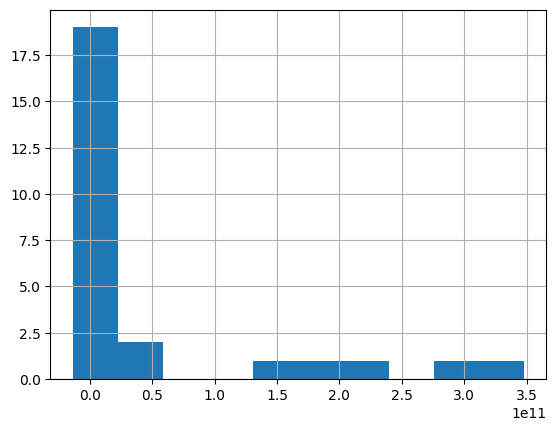

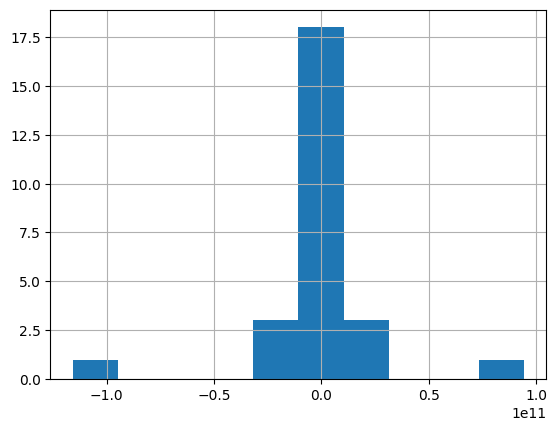

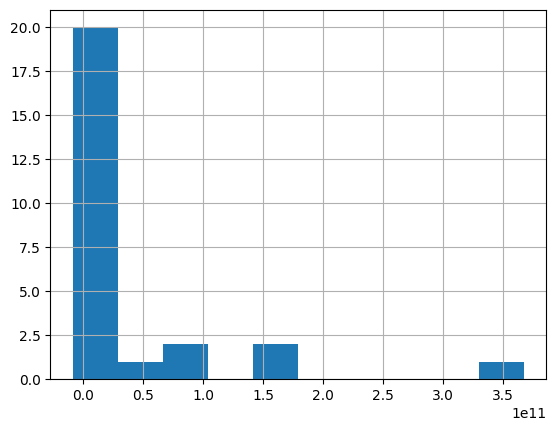

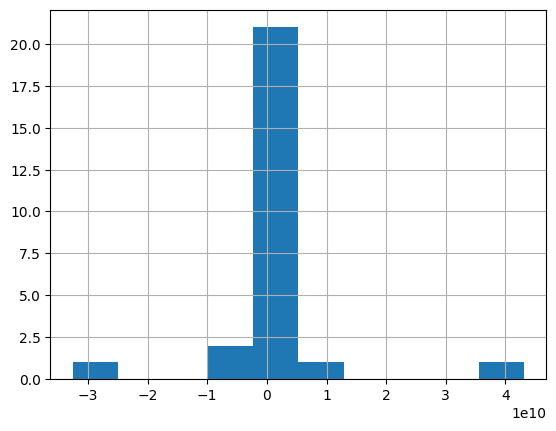

File already exists, erase before if you want to regenerate, or update version


In [29]:
dose_wdi_path = "../datasets/local_data/dose-wdi/"
# latest
# version = "0_3"
from missing_countries import version

dose_light = conn.read_csv(source_list=f"{dose_wdi_path}{version}/dose_light_combined_{year}_{version}.csv",table_name="dose_light")

### Preparing the data

In [30]:
# nice function from ibis
boundaries = boundaries.rename("snake_case")
dose_light = dose_light.rename("snake_case")

In [31]:
boundary_countries = conn.sql("Select distinct(gid_1) from boundaries;").to_pandas().iloc[:,0].to_list()
len(boundary_countries)

3473

In [32]:
boundaries.head()

┏━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ gid_0  ┃ name_0      ┃ gid_1   ┃ name_1     ┃ varname_1                 ┃ nl_name_1 ┃ type_1  ┃ engtype_1 ┃ cc_1   ┃ hasc_1 ┃ geometry                                                                         ┃ __index_level_0__ ┃
┡━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ string │ string      │ string  │ string     │ string                    │ string    │ string  │ string    │ string │ string │ geospatial:geometry                                                              │ int64             │
├────────┼─────────────┼─────────┼────────────┼───────────────────────────┼───────────┼─────────┼───────────┼────────┼────────┼──────────────────────────────────────────────────────────────────────────────────┼───────────────────┤
│ AFG    │ Afghanistan │ AFG.1_1 │ Badakhshan │ Badahšan                  │ NULL      │ Velayat │ Province  │ NULL   │ AF.BD  │ <POLYGON ((71.148 36.001, 71.142 35.993, 71.114 35.971, 71.102 35.956, 71.08...> │                 0 │
│ AFG    │ Afghanistan │ AFG.2_1 │ Badghis    │ Badghes|Badghisat|Badgis  │ NULL      │ Velayat │ Province  │ NULL   │ AF.BG  │ <POLYGON ((63.097 34.646, 63.082 34.658, 63.072 34.674, 63.069 34.681, 63.06...> │                 1 │
│ AFG    │ Afghanistan │ AFG.3_1 │ Baghlan    │ Baglan|Bughlan            │ NULL      │ Velayat │ Province  │ NULL   │ AF.BL  │ <POLYGON ((67.355 34.885, 67.355 34.888, 67.353 34.889, 67.348 34.896, 67.33...> │                 2 │
│ AFG    │ Afghanistan │ AFG.4_1 │ Balkh      │ Balh|Mazar-i-Sharif|Mazar │ NULL      │ Velayat │ Province  │ NULL   │ AF.BK  │ <POLYGON ((66.423 35.641, 66.449 35.654, 66.485 35.667, 66.499 35.669, 66.51...> │                 3 │
│ AFG    │ Afghanistan │ AFG.5_1 │ Bamyan     │ NULL                      │ NULL      │ Velayat │ Province  │ NULL   │ AF.BM  │ <POLYGON ((66.653 34.003, 66.659 34.017, 66.669 34.031, 66.672 34.038, 66.67...> │                 4 │
└────────┴─────────────┴─────────┴────────────┴───────────────────────────┴───────────┴─────────┴───────────┴────────┴────────┴──────────────────────────────────────────────────────────────────────────────────┴───────────────────┘

In [33]:
def head_rand(conn: ib.backends.duckdb.Backend, table: str, limit:[int,str]=5):
    query = f"select * from {table} order by random() limit {limit};"
    # alternative using the duckdb sample command
    # query_ = f"select * from {table} using sample {limit};"
    return conn.sql(query=query)


In [34]:
head_rand(conn=conn,table="dose_light",limit=10)


┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ country      ┃ gid_0  ┃ gid_1    ┃ grp_usd_2015 ┃ services_usd_2015 ┃ manufacturing_usd_2015 ┃ agriculture_usd_2015 ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ string       │ string │ string   │ float64      │ float64           │ float64                │ float64              │
├──────────────┼────────┼──────────┼──────────────┼───────────────────┼────────────────────────┼──────────────────────┤
│ Japan        │ JPN    │ JPN.44_1 │ 2.873751e+10 │      1.769360e+10 │           1.022593e+10 │         6.158575e+08 │
│ Russia       │ RUS    │ RUS.26_1 │ 3.479778e+09 │      2.171382e+09 │           1.120489e+09 │         1.879080e+08 │
│ Switzerland  │ CHE    │ CHE.19_1 │ 1.863989e+10 │      1.026323e+10 │           7.771130e+09 │         8.154673e+07 │
│ Russia       │ RUS    │ RUS.24_1 │ 2.878431e+09 │      1.597529e+09 │           6.879450e+08 │         5.929568e+08 │
│ Turkey       │ TUR    │ TUR.79_1 │ 2.789496e+09 │      1.131845e+09 │           1.219981e+09 │         1.079195e+08 │
│ South Korea  │ KOR    │ KOR.6_1  │ 3.081603e+10 │      2.352996e+10 │           9.613424e+09 │         1.475943e+08 │
│ Nigeria      │ NGA    │ NGA.15_1 │ 4.875312e+10 │      4.061886e+10 │           7.618530e+09 │         5.157358e+08 │
│ South Africa │ ZAF    │ ZAF.3_1  │ 1.083247e+11 │      7.239370e+10 │           2.412578e+10 │         4.341869e+08 │
│ Thailand     │ THA    │ THA.61_1 │ 9.577281e+08 │      4.680312e+08 │           9.641519e+07 │         3.932817e+08 │
│ El Salvador  │ SLV    │ SLV      │ 2.343824e+10 │      1.406600e+10 │           5.927280e+09 │         1.296080e+09 │
└──────────────┴────────┴──────────┴──────────────┴───────────────────┴────────────────────────┴──────────────────────┘

In [35]:
head_rand(conn=conn,table="boundaries",limit=10)

┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ GID_0  ┃ NAME_0                ┃ GID_1    ┃ NAME_1          ┃ VARNAME_1                         ┃ NL_NAME_1   ┃ TYPE_1       ┃ ENGTYPE_1    ┃ CC_1      ┃ HASC_1 ┃ geometry                                                                         ┃ __index_level_0__ ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ string │ string                │ string   │ string          │ string                            │ string      │ string       │ string       │ string    │ string │ geospatial:geometry                                                              │ int64             │
├────────┼───────────────────────┼──────────┼─────────────────┼───────────────────────────────────┼─────────────┼──────────────┼──────────────┼───────────┼────────┼──────────────────────────────────────────────────────────────────────────────────┼───────────────────┤
│ PRY    │ Paraguay              │ PRY.6_1  │ Caaguazú        │ NULL                              │ NULL        │ Departamento │ Department   │ NULL      │ PY.CG  │ <POLYGON ((-55.431 -25.539, -55.435 -25.539, -55.438 -25.537, -55.439 -25.53...> │              2532 │
│ BDI    │ Burundi               │ BDI.16_1 │ Rutana          │ NULL                              │ NULL        │ Province     │ Province     │ 003BDI015 │ BI.RT  │ <POLYGON ((30.126 -4.054, 30.126 -4.054, 30.126 -4.055, 30.126 -4.056, 30.12...> │               190 │
│ SOM    │ Somalia               │ SOM.5_1  │ Bay             │ Baay                              │ NULL        │ Gobolka      │ Region       │ NULL      │ SO.BY  │ <POLYGON ((43.32 1.63, 42.98 1.46, 42.9 1.52, 42.52 1.88, 42.4 1.95, 42.4 1....> │              2789 │
│ SVK    │ Slovakia              │ SVK.6_1  │ Trenčiansky     │ Trencín                           │ NULL        │ Kraj         │ Region       │ NULL      │ SK.TC  │ <POLYGON ((17.697 48.676, 17.697 48.676, 17.696 48.676, 17.695 48.675, 17.69...> │              2857 │
│ AUS    │ Australia             │ AUS.10_1 │ Victoria        │ NULL                              │ NULL        │ State        │ State        │ 2         │ AU.VI  │ <MULTIPOLYGON (((146.293 -39.158, 146.293 -39.157, 146.293 -39.157, 146.293 ...> │               154 │
│ DZA    │ Algeria               │ DZA.14_1 │ Chlef           │ El Asnam|Orléansville|Ech Cheliff │ ولاية الشلف │ Wilaya       │ Province     │ 2         │ DZ.CH  │ <POLYGON ((1.648 35.94, 1.648 35.94, 1.649 35.94, 1.648 35.94, 1.648 35.941,...> │               760 │
│ DOM    │ Dominican Republic    │ DOM.30_1 │ Santiago        │ Santiago de los Caballeros        │ NULL        │ Provincia    │ Province     │ NULL      │ DO.ST  │ <POLYGON ((-70.583 19.395, -70.582 19.392, -70.581 19.389, -70.579 19.387, -...> │               743 │
│ GAB    │ Gabon                 │ GAB.8_1  │ Ogooué-Maritime │ NULL                              │ NULL        │ Province     │ Province     │ NULL      │ GA.OM  │ <MULTIPOLYGON (((9.158 -2.075, 9.158 -2.075, 9.158 -2.075, 9.158 -2.075, 9.1...> │               941 │
│ KEN    │ Kenya                 │ KEN.37_1 │ Samburu         │ NULL                              │ NULL        │ County       │ County       │ 25        │ KE.SA  │ <POLYGON ((37.493 0.589, 37.492 0.589, 37.492 0.589, 37.492 0.59, 37.492 0.5...> │              1496 │
│ STP    │ São Tomé and Príncipe │ STP.1_1  │ Príncipe        │ NULL                              │ NULL        │ Concelho     │ Municipality │ NULL      │ ST.PR  │ <MULTIPOLYGON (((7.293 1.345, 7.293 1.344, 7.293 1.344, 7.293 1.343, 7.294 1...> │ 

In [36]:
# subsetting the boundaries data:
boundary_columns = ["GID_0","NAME_0","GID_1","NAME_1","geometry"]
boundary_columns = [str(x).lower() for x in boundary_columns]

boundaries = boundaries.select(boundary_columns)

In [37]:
# head_rand(conn=conn,table="boundaries",limit=10)
boundaries.count()

┌──────┐
│ 3473 │
└──────┘

In [38]:
boundaries.gid_0.value_counts().execute().head(5)
# boundaries.filter(_.name_0=="Colombia"
#                   ).execute().tail(20)

,gid_0,gid_0_count
0,AND,7
1,BEN,12
2,BGR,28
3,BIH,3
4,BWA,16


In [ ]:
# dose_light[dose_light.gid_0=="VEN"].execute()

In [39]:
boundaries_1 = conn.sql("""select * EXCLUDE (geometry)
                        , ST_Centroid(geometry::GEOMETRY) as centr
                        , geometry::GEOMETRY as geometry 
                        from boundaries;""")

In [40]:
boundaries_1.head()

┏━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ GID_0  ┃ NAME_0      ┃ GID_1   ┃ NAME_1     ┃ VARNAME_1                 ┃ NL_NAME_1 ┃ TYPE_1  ┃ ENGTYPE_1 ┃ CC_1   ┃ HASC_1 ┃ __index_level_0__ ┃ centr                   ┃ geometry                                                                         ┃
┡━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ string │ string      │ string  │ string     │ string                    │ string    │ string  │ string    │ string │ string │ int64             │ geospatial:geometry     │ geospatial:geometry                                                              │
├────────┼─────────────┼─────────┼────────────┼───────────────────────────┼───────────┼─────────┼───────────┼────────┼────────┼───────────────────┼─────────────────────────┼──────────────────────────────────────────────────────────────────────────────────┤
│ AFG    │ Afghanistan │ AFG.1_1 │ Badakhshan │ Badahšan                  │ NULL      │ Velayat │ Province  │ NULL   │ AF.BD  │                 0 │ <POINT (71.459 37.033)> │ <POLYGON ((71.148 36.001, 71.142 35.993, 71.114 35.971, 71.102 35.956, 71.08...> │
│ AFG    │ Afghanistan │ AFG.2_1 │ Badghis    │ Badghes|Badghisat|Badgis  │ NULL      │ Velayat │ Province  │ NULL   │ AF.BG  │                 1 │ <POINT (63.753 35.14)>  │ <POLYGON ((63.097 34.646, 63.082 34.658, 63.072 34.674, 63.069 34.681, 63.06...> │
│ AFG    │ Afghanistan │ AFG.3_1 │ Baghlan    │ Baglan|Bughlan            │ NULL      │ Velayat │ Province  │ NULL   │ AF.BL  │                 2 │ <POINT (68.714 35.705)> │ <POLYGON ((67.355 34.885, 67.355 34.888, 67.353 34.889, 67.348 34.896, 67.33...> │
│ AFG    │ Afghanistan │ AFG.4_1 │ Balkh      │ Balh|Mazar-i-Sharif|Mazar │ NULL      │ Velayat │ Province  │ NULL   │ AF.BK  │                 3 │ <POINT (67.135 36.648)> │ <POLYGON ((66.423 35.641, 66.449 35.654, 66.485 35.667, 66.499 35.669, 66.51...> │
│ AFG    │ Afghanistan │ AFG.5_1 │ Bamyan     │ NULL                      │ NULL      │ Velayat │ Province  │ NULL   │ AF.BM  │                 4 │ <POINT (67.181 34.721)> │ <POLYGON ((66.653 34.003, 66.659 34.017, 66.669 34.031, 66.672 34.038, 66.67...> │
└────────┴─────────────┴─────────┴────────────┴───────────────────────────┴───────────┴─────────┴───────────┴────────┴────────┴───────────────────┴─────────────────────────┴──────────────────────────────────────────────────────────────────────────────────┘

In [41]:
boundaries_1.filter(_.GID_0=="LAO").head(3)

┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ GID_0  ┃ NAME_0 ┃ GID_1   ┃ NAME_1      ┃ VARNAME_1                                                       ┃ NL_NAME_1 ┃ TYPE_1  ┃ ENGTYPE_1 ┃ CC_1   ┃ HASC_1 ┃ __index_level_0__ ┃ centr                    ┃ geometry                                                                         ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ string │ string │ string  │ string      │ string                                                          │ string    │ string  │ string    │ string │ string │ int64             │ geospatial:geometry      │ geospatial:geometry                                                              │
├────────┼────────┼─────────┼─────────────┼─────────────────────────────────────────────────────────────────┼───────────┼─────────┼───────────┼────────┼────────┼───────────────────┼──────────────────────────┼──────────────────────────────────────────────────────────────────────────────────┤
│ LAO    │ Laos   │ LAO.1_1 │ Attapu      │ Attopu|Atpu|Attapeu|Attopeu|Muang Mai                           │ NULL      │ Khoueng │ Province  │ NULL   │ LA.AT  │              1578 │ <POINT (106.945 14.794)> │ <POLYGON ((107.525 14.731, 107.523 14.729, 107.522 14.728, 107.521 14.728, 1...> │
│ LAO    │ Laos   │ LAO.2_1 │ Bokeo       │ NULL                                                            │ NULL      │ Khoueng │ Province  │ NULL   │ LA.BK  │              1579 │ <POINT (100.643 20.351)> │ <POLYGON ((100.761 19.874, 100.761 19.87, 100.759 19.865, 100.755 19.864, 10...> │
│ LAO    │ Laos   │ LAO.3_1 │ Bolikhamxai │ Bolikhamsai|Bolikhamxay|Borikhamzay|Borikane|Borikhan|Borikhane │ NULL      │ Khoueng │ Province  │ NULL   │ LA.BL  │              1580 │ <POINT (104.26 18.489)>  │ <POLYGON ((102.904 18.294, 102.906 18.296, 102.908 18.301, 102.909 18.307, 1...> │
└────────┴────────┴─────────┴─────────────┴─────────────────────────────────────────────────────────────────┴───────────┴─────────┴───────────┴────────┴────────┴───────────────────┴──────────────────────────┴──────────────────────────────────────────────────────────────────────────────────┘

### Working only on centroids

In [42]:
boundaries_centr = boundaries_1.rename("snake_case").execute()

In [43]:
# regions to merge with DOSE

boundaries_1_centr = boundaries_centr.dissolve("gid_1")
boundaries_1_centr["centr"] = boundaries_1_centr.geometry.centroid
# 
# boundaries_1_centr.drop(columns="geom",inplace=True)
boundaries_1_centr.reset_index(inplace=True,drop=False)
# 
boundaries_1_centr = boundaries_1_centr.astype({"gid_1":str})

# boundaries_1_centr.dtypes

In [44]:
gadm_gid_0_filename = f"{out_path}gadm_gid_0.parquet"

In [45]:
if not os.path.exists(gadm_gid_0_filename):
    boundaries_0_centr = conn.sql(
    """SELECT 
            gid_0, 
            ST_Union_Agg(geometry) as geometry 
            from 
                (select * EXCLUDE (geometry)
                            , ST_Centroid(geometry::GEOMETRY) as centr
                            , geometry::GEOMETRY as geometry 
                            from boundaries) 
            GROUP BY gid_0;""").execute() # boundaries_1
    
    boundaries_0_centr.set_crs(epsg=4326,inplace=True)
    boundaries_0_centr.to_parquet(gadm_gid_0_filename)

In [46]:
boundaries_0_centr = gpd.read_parquet(gadm_gid_0_filename)

In [47]:
boundaries_0_centr.columns = [x.lower() for x in boundaries_0_centr.columns]

In [48]:
# boundaries_0_centr = boundaries_centr[["gid_0","geometry"]].set_geometry("geometry").set_crs(epsg=4326).dissolve(by="gid_0")
boundaries_0_centr["centr"] = boundaries_0_centr.geometry.centroid
# 
# boundaries_0_centr.drop(columns="geom",inplace=True)
boundaries_0_centr.reset_index(inplace=True,drop=False)
# 
boundaries_0_centr = boundaries_0_centr.astype({"gid_0":str})
# boundaries_0_centr.dtypes

/var/folders/jw/j3253m6j4n7454gchq5258q80000gp/T/ipykernel_37993/3513629616.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  boundaries_0_centr["centr"] = boundaries_0_centr.geometry.centroid


In [49]:
dose_light.count()

┌──────┐
│ 1676 │
└──────┘

In [50]:
dose_light_geo_ = dose_light.execute()

In [51]:
dose_light_geo_ = dose_light_geo_.astype({"gid_1" : str})

In [52]:
dose_light_geo_[dose_light_geo_.gid_1=="LAO"]

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
1608,Lao PDR,LAO,LAO,1.442638e+10,6.371983e+09,3.995147e+09,2.537277e+09


In [ ]:
# boundaries_1_centr.dtypes

In [53]:
dose_light_geo = gpd.GeoDataFrame(dose_light_geo_.merge(boundaries_1_centr[["gid_1","centr","geometry"]],on="gid_1",how="left"))

In [ ]:
dose_light_geo[dose_light_geo.gid_1=="LAO"]

AttributeError: 'NoneType' object has no attribute 'copy'

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015,centr,geometry
1608,Lao PDR,LAO,LAO,1.442638e+10,6.371983e+09,3.995147e+09,2.537277e+09,None,None


In [55]:
missing_geoms = dose_light_geo.centr.isna()

In [56]:
missing_countries = dose_light_geo_.loc[missing_geoms,"gid_0"].to_list()

In [57]:
boundaries_0_centr_missing = boundaries_0_centr[boundaries_0_centr.gid_0.isin(missing_countries)].set_index("gid_0")
dose_light_geo.set_index("gid_0",inplace=True)

In [58]:
boundaries_0_centr_missing.head()

AttributeError: 'NoneType' object has no attribute 'copy'

,index,geometry,centr
gid_0,,,
BDI,0,"POLYGON ((29.23162 -3.25516, 29.23092 -3.25393...",POINT (29.88982 -3.36766)
BFA,1,"POLYGON ((-4.64197 12.07223, -4.64068 12.07887...",POINT (-1.74566 12.27429)
BMU,2,"MULTIPOLYGON (((-64.74194 32.29945, -64.74194 ...",POINT (-64.76719 32.30941)
GNQ,7,"MULTIPOLYGON (((5.65014 -1.44648, 5.65022 -1.4...",POINT (10.33233 1.70166)
HTI,9,"MULTIPOLYGON (((-71.79884 18.68888, -71.79767 ...",POINT (-72.68394 18.93739)


In [59]:
dose_light_geo.loc[missing_countries,["centr","geometry"]] = boundaries_0_centr_missing[["centr","geometry"]]
dose_light_geo.reset_index(inplace=True,drop=False)

In [60]:
# dose_light_geo.set_geometry("geometry",inplace=True).set_crs(epsg=4326,inplace=True)
# dose_light_geo.set_crs(epsg=4326,inplace=True)

dose_light_geo.set_geometry("centr",inplace=True)
dose_light_geo.set_crs(epsg=4326,inplace=True)

AttributeError: 'NoneType' object has no attribute 'copy'

,gid_0,country,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015,centr,geometry
0,ALB,Albania,ALB.1_1,4.341915e+08,2.009631e+08,9.449606e+07,8.588401e+07,POINT (20.09077 40.6285),"POLYGON ((20.3794 40.43518, 20.37653 40.4361, ..."
1,ALB,Albania,ALB.2_1,3.719427e+08,1.721516e+08,8.094841e+07,7.357106e+07,POINT (20.24953 41.58911),"POLYGON ((20.42208 41.2819, 20.4225 41.28206, ..."
2,ALB,Albania,ALB.3_1,1.113524e+09,5.153885e+08,2.423439e+08,2.202575e+08,POINT (19.63037 41.44733),"POLYGON ((19.63813 41.34107, 19.6356 41.33656,..."
3,ALB,Albania,ALB.4_1,7.954835e+08,3.681851e+08,1.731265e+08,1.573483e+08,POINT (20.18645 41.04003),"POLYGON ((20.43677 40.84906, 20.43671 40.8485,..."
4,ALB,Albania,ALB.5_1,1.345159e+09,6.225993e+08,2.927561e+08,2.660753e+08,POINT (19.62053 40.77463),"POLYGON ((19.74395 40.45158, 19.74499 40.45683..."
...,...,...,...,...,...,...,...,...,...
1671,VIR,Virgin Islands (U.S.),VIR,3.663000e+09,NaN,NaN,NaN,POINT (-64.80277 17.9717),"MULTIPOLYGON (((-64.76319 17.68597, -64.76264 ..."
1672,PSE,West Bank and Gaza,PSE,1.397240e+10,8.618600e+09,2.295000e+09,1.035200e+09,POINT (35.20918 31.91606),"MULTIPOLYGON (((34.26801 31.22361, 34.26234 31..."
1673,YEM,"Yemen, Rep.",YEM,4.244449e+10,1.779608e+10,1.437432e+10,8.576307e+09,POINT (47.58276 15.90484),"MULTIPOLYGON (((43.41653 12.66819, 43.41681 12..."
1674,ZMB,Zambia,ZMB,2.125122e+10,1.194752e+10,7.152575e+09,1.058488e+09,POINT (27.79264 -13.46228),"POLYGON ((22.00032 -13.54409, 22.00025 -13.450..."


### Exporting

In [61]:
dose_light_geo = dose_light_geo.set_geometry("geometry")
dose_light_geo["x"]=dose_light_geo.centr.x
dose_light_geo["y"]=dose_light_geo.centr.y

In [62]:
# contains some missing bits. 
dose_wdi_geo_filename = f"dose_wdi_geo_{version}"
dose_wdi_geo_filepath = f"../datasets/local_data/dose-wdi/{version}/{dose_wdi_geo_filename}.parquet"

if not os.path.exists(dose_wdi_geo_filepath):
    dose_light_geo.to_parquet(dose_wdi_geo_filepath)
else :
    raise Warning(f"File already exists at '{dose_wdi_geo_filepath}'.")

Warning: File already exists at '../datasets/local_data/dose-wdi/0_4/dose_wdi_geo_0_4.parquet'.

In [ ]:
! jupyter nbconvert missing_countries_geo.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags rm_cell --to python

## Plotting

### Set up color palette for the map.

In [ ]:
viridis = color_palette("viridis", as_cmap=True) # the sns function
viridis

In [ ]:
col_pal = pypal.load_cmap("Apricot",reverse=True)
col_pal.N

In [ ]:
# in scalenav
# def cmap(input, palette):
#     input = np.nan_to_num(input).tolist()
#     m = np.max(input)
#     l = palette.N
#     print("Max input : {}, palette colors : {}".format(m,l))
#     return [[int(255*j) for j in palette(int(x/m*l))] for x in input] #

In [ ]:
cols = cmap(np.log1p(dose_light_geo["grp_usd_2015"]),palette=col_pal)
dose_light_geo["color"] = cols
dose_light_geo["radius"] = np.log1p(dose_light_geo["grp_usd_2015"])
dose_light_geo.head(3)

#### Deck map

In [ ]:
# final data wrangling before plotting

def simplify_geom(geom,**args):
    try: 
        return geom.simplify(**args)
    except:
        return geom


dose_light_geo["geometry_simple"] = dose_light_geo["geometry"].apply(lambda geom: simplify_geom(geom=geom,tolerance=0.05,preserve_topology=True))
dose_light_geo.head()

In [ ]:
dose_light_geo.set_geometry(col="geometry_simple",crs=4326,inplace=True)

In [ ]:
# viewport = pdk.data_utils.compute_view(points=compact_geo_downscaled[['x', 'y']], view_proportion=0.9)
viewport = pdk.ViewState(longitude=0,latitude=0,zoom=2)

In [ ]:
# Deck map showing the combined layers for each variable

gdp_layer = pdk.Layer(
    "ScatterplotLayer",
    dose_light_geo[["country","x","y","color","radius","gid_1","services_usd_2015","manufacturing_usd_2015","agriculture_usd_2015","grp_usd_2015"]],
    pickable=True,
    extruded=False,
    filled=True,
    stroked=True,
    opacity=.6,
    get_radius=["radius"],
    radius_scale=2000,
    radius_min_pixels=1,
    radius_max_pixels=15,
    get_position = ["x","y"],
    # get_polygons = "geom",
    get_fill_color = "color", #"[255*log_value/20,100,120]",
    get_line_color= [255, 255, 255, 0],
    line_width_min_pixels=0,
    line_width_max_pixels=1,
    )


# h3_layer = pdk.Layer(
#     "H3HexagonLayer",
#     dose_light_geo[["gdp","hex","color"]],
#     pickable=True,
#     stroked=True,
#     filled=True,
#     opacity=.5,
#     extruded=False,
#     get_hexagon="hex",
#     get_fill_color= "color", #[230, 200, 180, 255],
#     get_line_color=[0, 0, 0, 0],
#     line_width_min_pixels=1,
# )

# polygon_layer = pdk.Layer(
#     "GeoJsonLayer",
#     dose_light_geo[["gdp_color", "services_color","manuf_color","agri_color","geometry_simple"]],
#     id="geojson",
#     opacity=0.7,
#     stroked=False,
#     # get_polygon="geometry_simple",
#     filled=True,
#     # extruded=True,
#     # wireframe=True,
#     # get_elevation="elevation",
#     get_fill_color="gdp_color",
#     get_line_color=[255, 255, 255, 0],
#     auto_highlight=True,
#     pickable=True,
# )



In [ ]:
r = pdk.Deck(layers=[
    gdp_layer,
                    #  polygon_layer
                     ]
            ,initial_view_state=viewport
            ,tooltip={"html": """<h3>{country} : {gid_1}</h3> 
                      <p> Services :  {services_usd_2015} </p> 
                      <p> Manufacturing: {manufacturing_usd_2015} </p>
                      <p> Agriculture: {agriculture_usd_2015} </p>
                      <p> Total: {grp_usd_2015} </p>
                      """}
            ,
            # ,mapbox_key="MAPBOX_API_KEY"
            )

In [ ]:
r.to_html("../deck_maps/dose-wdi_geometries_vis.html",iframe_height=800)

### Other maps:

In [ ]:
area = dose_light_geo.to_crs('ESRI:54009').area
# dose_light_geo["geometry_simple"].to_crs('ESRI:54009').area

In [ ]:
dose_light_geo["gdp_color_var"] = np.log1p(dose_light_geo["grp_usd_2015"]/area*10_000)
dose_light_geo["services_color_var"] = np.log1p(dose_light_geo["services_usd_2015"]/area*10_000)
dose_light_geo["manuf_color_var"] = np.log1p(dose_light_geo["manufacturing_usd_2015"]/area*10_000)
dose_light_geo["agri_color_var"] = np.log1p(dose_light_geo["agriculture_usd_2015"]/area*10_000)

In [ ]:
dose_light_geo["gdp_color"] = cmap(dose_light_geo["gdp_color_var"],palette=col_pal)
dose_light_geo["services_color"] = cmap(dose_light_geo["services_color_var"],palette=col_pal)
dose_light_geo["manuf_color"] = cmap(dose_light_geo["manuf_color_var"],palette=col_pal)
dose_light_geo["agri_color"] = cmap(dose_light_geo["agri_color_var"],palette=col_pal)

In [ ]:
dose_light_geo.head()

In [ ]:
# vars=["gdp","services",]
ax = dose_light_geo.plot(column="agri_color_var")
ax.set_axis_off()
ax.set_title("World GDP (agriculture)")
plt.savefig("world_agri.png")

In [ ]:
## Datashader tests 

In [ ]:
# ! export DASK_DATAFRAME__QUERY_PLANNING=False

In [ ]:
# import datashader as ds 

# cvs = ds.Canvas(plot_width=650, plot_height=400)
# agg = cvs.polygons(dose_light_geo, geometry='geometry',agg=ds.any())
# tf.shade(agg)